In [2]:
# to install
import subprocess
# subprocess.call("pip install 'plotnine[all]'", shell=True)

In [3]:
import pyspark 
import json
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import DataFrameReader, SQLContext, SparkSession
import pyspark.sql.functions as func
import pyspark.sql.types as types

conf = SparkConf()
conf.set('spark.jars', "/home/share/postgresql-42.2.12.jar")
conf.set('spark.driver.extraClassPath', "/home/share/postgresql-42.2.12.jar")
sc = pyspark.SparkContext(conf = conf).getOrCreate()
sql_con = SQLContext(sc)
session = SparkSession.builder.config(conf=conf).getOrCreate()

def clean_column_names(df):
    for column in adult_df.columns:
        new_col_name = column.strip().replace('-', '_')
        df = df.withColumnRenamed(column, new_col_name)
    return df

In [4]:
adult_df = session.read.csv("/home/share/datasets/adult/adult.data", header=True, inferSchema=True)
adult_df = clean_column_names(adult_df)

In [5]:
import plotnine as p9
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, labs
from plotnine.data import mtcars

from scipy import stats
import pandas as pd

%matplotlib inline

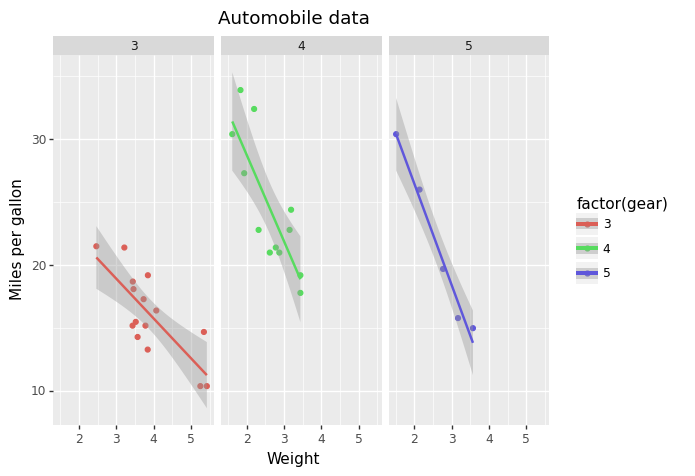

<ggplot: (8748094674081)>

In [6]:
(
    ggplot(mtcars, aes(x='wt', y='mpg', color='factor(gear)'))
    + geom_point()
    + stat_smooth(method='lm')
    + facet_wrap('~gear')
    + labs(title="Automobile data", x="Weight", y="Miles per gallon")
)

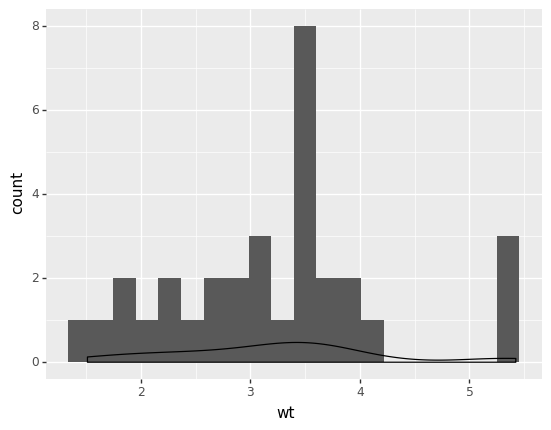

<ggplot: (8748088198861)>


In [7]:
def histogram(df, column_name):
    print(
        ggplot(df, aes(x=column_name))
        + p9.geom_histogram(bins=20)
        + p9.geom_density()
    )

histogram(mtcars, 'wt')

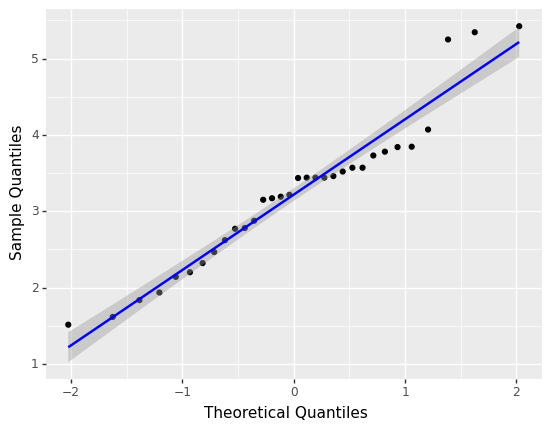

<ggplot: (8748088171337)>


In [8]:
def normal_qq_plot(df_column):
    tq = stats.probplot(df_column, dist="norm")
    df = pd.DataFrame(
        data = {
            'Theoretical Quantiles': tq[0][0],
            "Sample Quantiles": df_column.sort_values() 
        }
    )
    print(
        p9.ggplot(df)
        + p9.aes(x="Theoretical Quantiles",y="Sample Quantiles") 
        + p9.geom_point() 
        + p9.stat_smooth(method='lm', color='blue')
    )

normal_qq_plot(mtcars.wt)

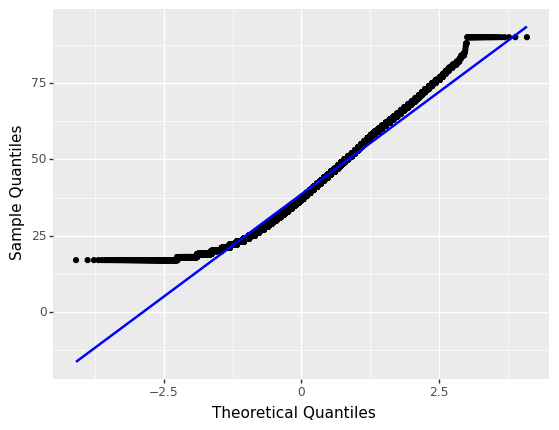

<ggplot: (8748088267481)>


In [9]:
normal_qq_plot(adult_df.toPandas().age)

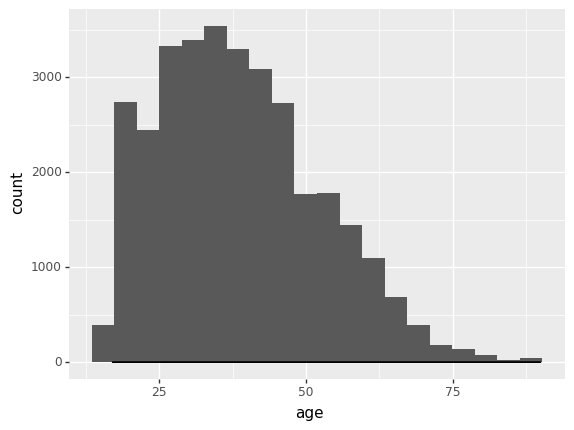

<ggplot: (8748088170381)>


In [10]:
histogram(adult_df.toPandas(), 'age')

In [44]:
print(adult_df.select('native_country').distinct().count())
per_country = adult_df.groupBy('native_country').count()
per_country

42


DataFrame[native_country: string, count: bigint]

In [45]:
country_pd = per_country.toPandas()

In [46]:
country_pd.columns

Index(['native_country', 'count'], dtype='object')

In [25]:
country_pd

,native_country,count
0,Holand-Netherlands,1
1,Scotland,12
2,Honduras,13
3,Hungary,13
4,Outlying-US(Guam-USVI-etc),14
5,Yugoslavia,16
6,Laos,18
7,Thailand,18
8,Cambodia,19
9,Trinadad&Tobago,19


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


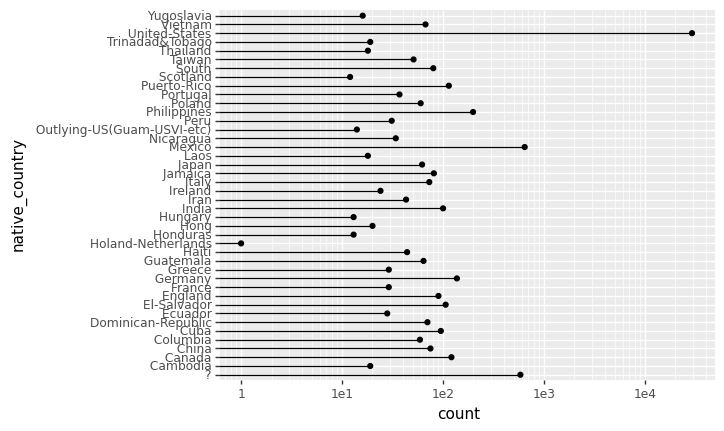

<ggplot: (8748087993333)>


In [60]:
# Dot plot of cases per native country
def log_dot_plot(df, count_column, label_column):
    return (
        ggplot(df) 
        + geom_point(aes(x = count_column, y = label_column))
        + p9.scale_x_continuous(trans = "log10")
#         + p9.labs(x="count", y="Native Country")
#         + p9.guides(fill=p9.guide_legend(keywidth=0.2,keyheight=0.15,default_unit="cm"))
        + p9.geom_segment(aes(x = count_column, y = label_column, xend = 0, yend=label_column))
    )

print(log_dot_plot(country_pd, 'count', 'native_country'))

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


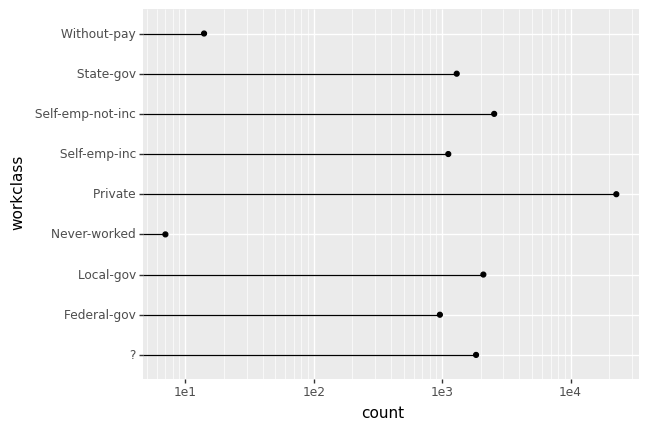

<ggplot: (8748086584089)>


In [61]:
per_job = adult_df.groupBy('workclass').count()
plot = log_dot_plot(per_job.toPandas(), count_column='count', label_column='workclass')
print(plot)

In [75]:
# Getting probabilities of different incomes categories
df1 = adult_df.groupBy('workclass','income').count()
df2 = adult_df.groupBy('workclass').count().withColumnRenamed('count', 'total')
df3 = df1.join(df2, ['workclass'], how = 'inner')

df3 = df3.withColumn('freq', func.col('count')/func.col('total'))
df3.show()


+-----------------+------+-----+-----+-------------------+
|        workclass|income|count|total|               freq|
+-----------------+------+-----+-----+-------------------+
|        Local-gov| <=50K| 1476| 2093| 0.7052078356426182|
|      Federal-gov| <=50K|  589|  960| 0.6135416666666667|
| Self-emp-not-inc|  >50K|  724| 2541| 0.2849271940181031|
|                ?|  >50K|  191| 1836|0.10403050108932461|
|     Self-emp-inc| <=50K|  494| 1116|0.44265232974910396|
|        State-gov| <=50K|  945| 1298| 0.7280431432973806|
|        Local-gov|  >50K|  617| 2093|0.29479216435738176|
|          Private|  >50K| 4963|22696|0.21867289390200917|
| Self-emp-not-inc| <=50K| 1817| 2541| 0.7150728059818969|
|        State-gov|  >50K|  353| 1298|0.27195685670261943|
|     Self-emp-inc|  >50K|  622| 1116|  0.557347670250896|
|          Private| <=50K|17733|22696| 0.7813271060979908|
|                ?| <=50K| 1645| 1836| 0.8959694989106753|
|     Never-worked| <=50K|    7|    7|                1.

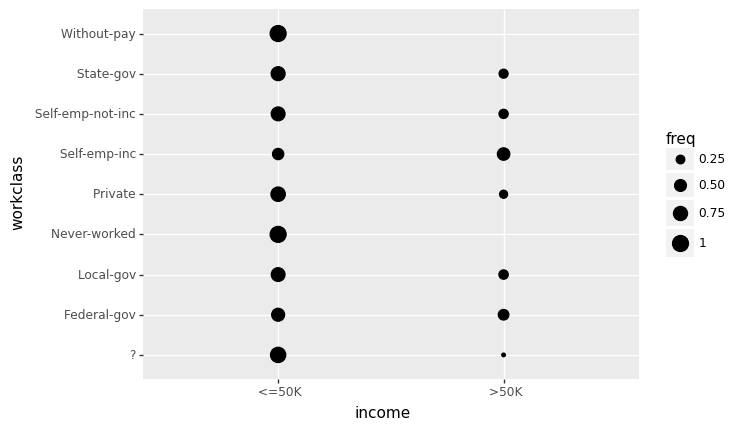

<ggplot: (8748086899485)>

In [76]:
(
     ggplot(df3.toPandas()) 
        + geom_point(aes(x = 'income', y = 'workclass', size='freq'))
)

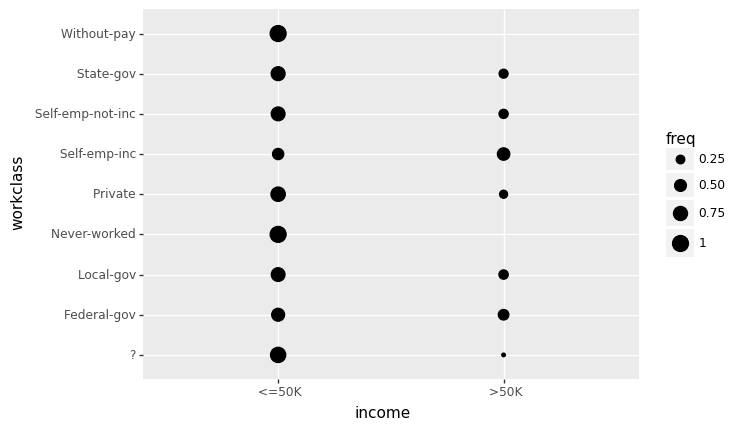

<ggplot: (8748088239805)>


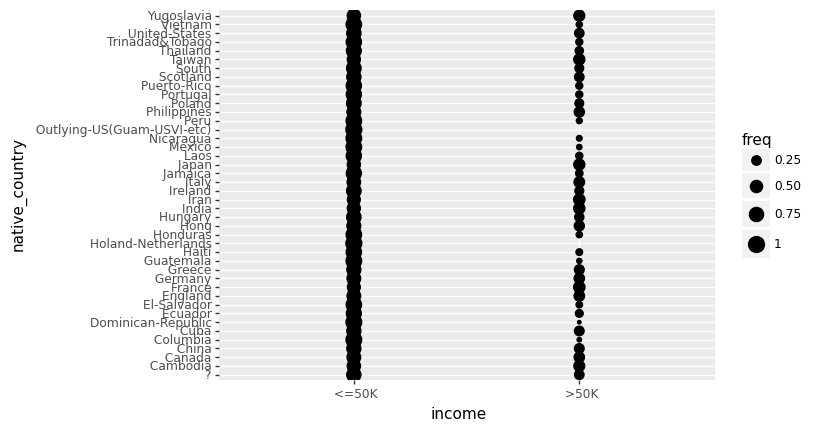

<ggplot: (8748087505461)>


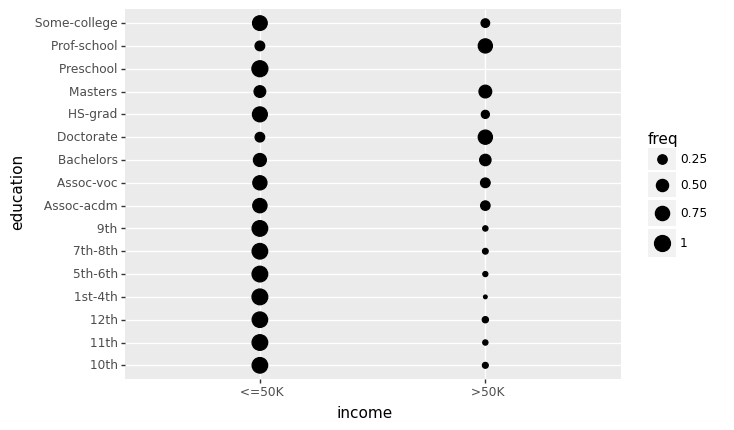

<ggplot: (8748088239785)>


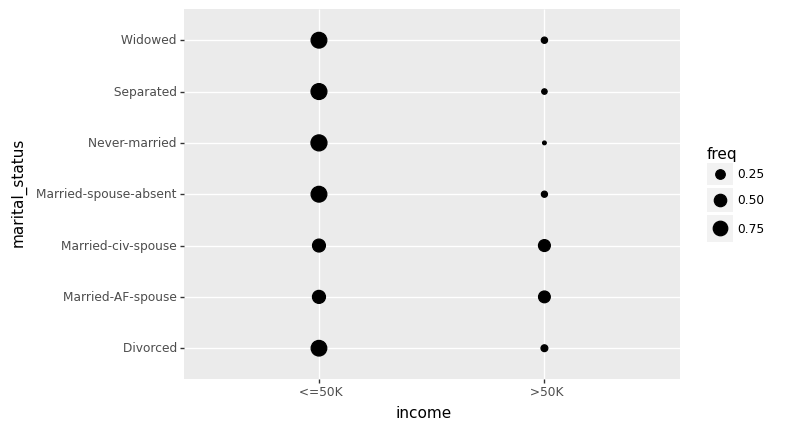

<ggplot: (8748087804205)>


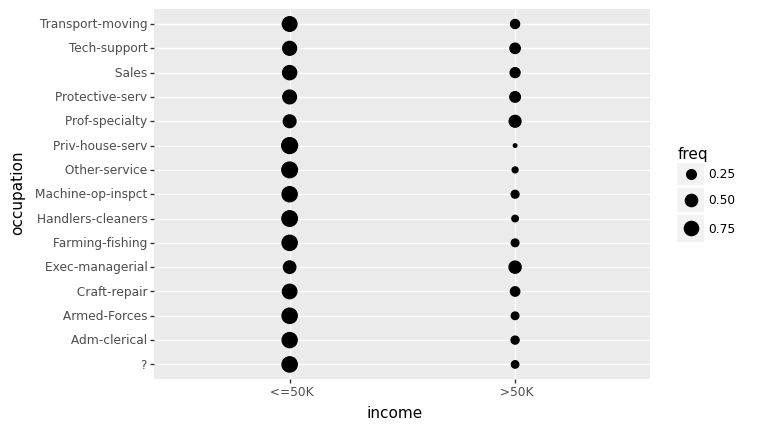

<ggplot: (8748087949661)>


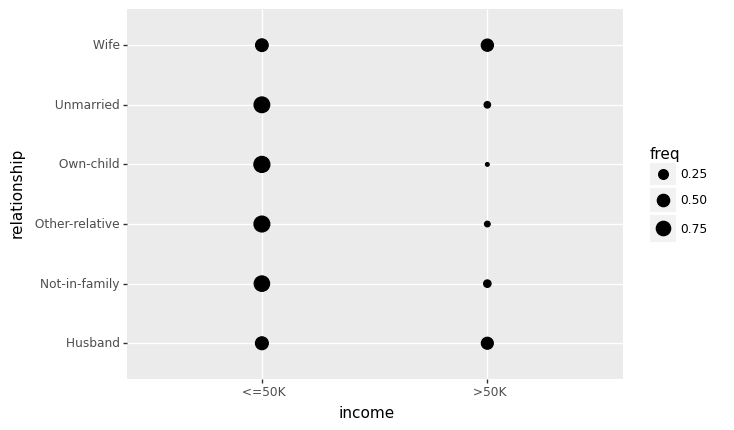

<ggplot: (8748087691629)>


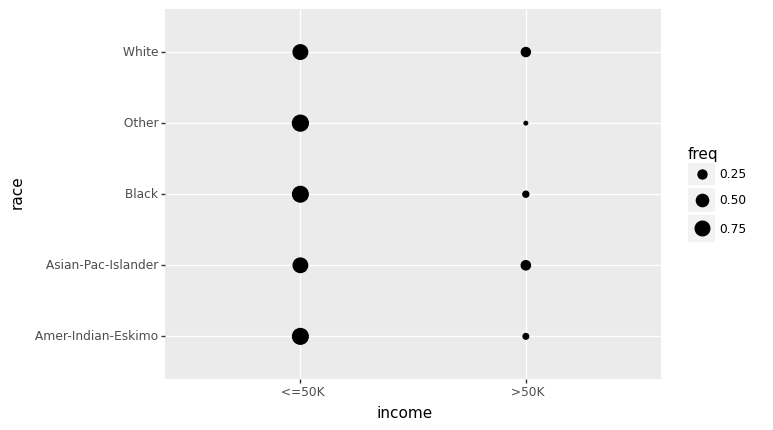

<ggplot: (8748087509109)>


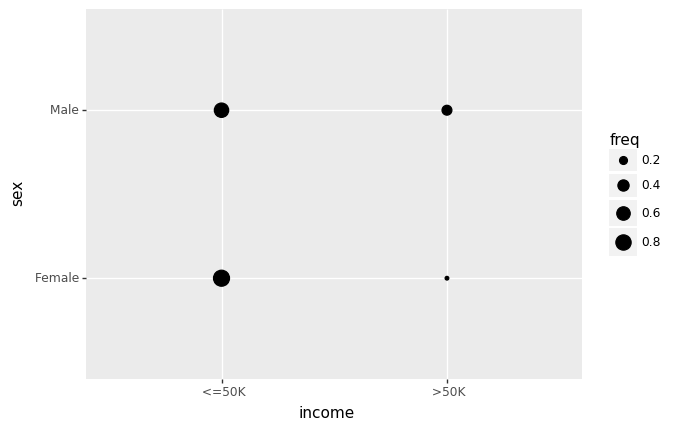

<ggplot: (8748087559653)>


In [78]:
# Exploring differences in income distribution by factors
factor_cols = [col for col, dtype in adult_df.dtypes if dtype == 'string' and col != 'income']
for col in factor_cols:    
    df1 = adult_df.groupBy(col,'income').count()
    df2 = adult_df.groupBy(col).count().withColumnRenamed('count', 'total')
    df3 = df1.join(df2, [col], how = 'inner')

    df3 = df3.withColumn('freq', func.col('count')/func.col('total'))
    print(
     ggplot(df3.toPandas()) 
        + geom_point(aes(x = 'income', y = col, size='freq'))
    )

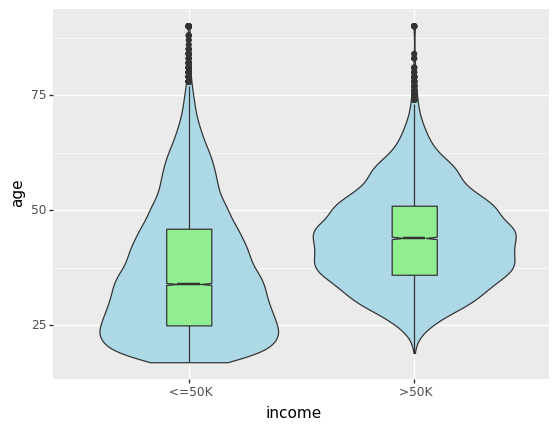

<ggplot: (8748086195205)>


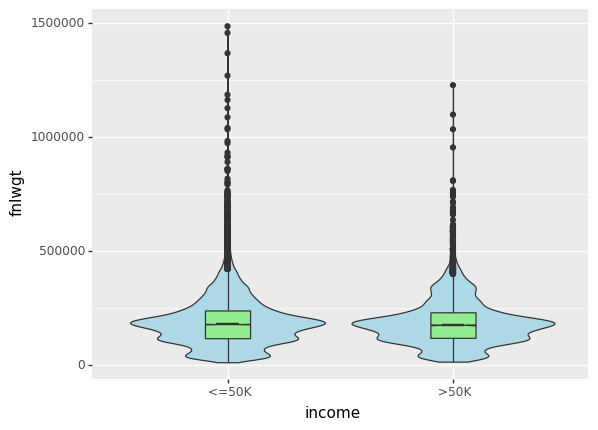

<ggplot: (8748086656501)>


/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_crossbar.py:83: PlotnineWarning: Notch went outside hinges. Try setting notch=False.
  " Try setting notch=False.", PlotnineWarning)


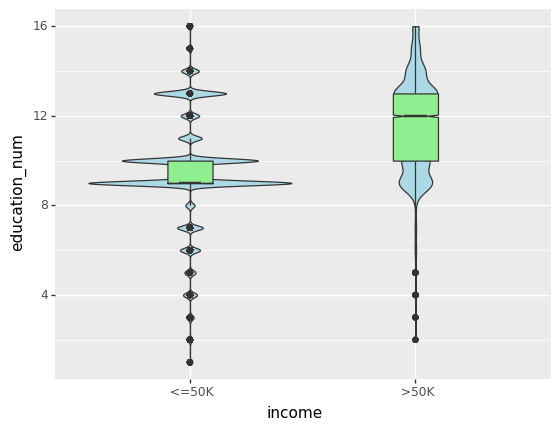

<ggplot: (8748080172653)>


/opt/conda/lib/python3.7/site-packages/plotnine/geoms/geom_crossbar.py:83: PlotnineWarning: Notch went outside hinges. Try setting notch=False.
  " Try setting notch=False.", PlotnineWarning)


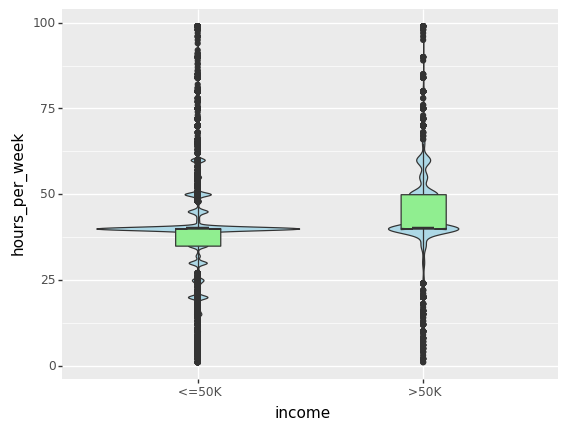

<ggplot: (8748085213765)>


In [93]:
# Exploring distribution of numeric variables by income category
numeric_cols = [col for col, dtype in adult_df.dtypes if dtype in ['double', 'int'] 
                and col not in ['income', 'capital_gain', 'capital_loss']]
for col in numeric_cols:
    print(
        ggplot(adult_df.toPandas(), aes(x='income', y=col))
        + p9.geom_violin(fill="lightblue")
        + p9.geom_boxplot(fill="lightgreen", notch=True, width = 0.2)
    )

In [85]:
adult_df.dtypes

[('age', 'int'),
 ('workclass', 'string'),
 ('fnlwgt', 'double'),
 ('education', 'string'),
 ('education_num', 'double'),
 ('marital_status', 'string'),
 ('occupation', 'string'),
 ('relationship', 'string'),
 ('race', 'string'),
 ('sex', 'string'),
 ('capital_gain', 'double'),
 ('capital_loss', 'double'),
 ('hours_per_week', 'double'),
 ('native_country', 'string'),
 ('income', 'string')]

In [108]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer, VectorAssembler, StringIndexer, OneHotEncoderEstimator

In [103]:
v_assembler = VectorAssembler(inputCols = ['age','education','education_num'], outputCol = 'features')
adult_df_lr = v_assembler.transform(adult_df).select('features','income')
adult_df_lr.show(3)

IllegalArgumentException: 'Data type string of column education is not supported.'

In [118]:
str_indexer = StringIndexer(inputCol='education', outputCol='education_cat')
str_ind2 = StringIndexer(inputCol='native_country', outputCol='native_country_cat')
pipeline = Pipeline(stages=[str_indexer, str_ind2])
adult_cat = pipeline.fit(adult_df).transform(adult_df)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f4d2b043d40>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'


In [122]:
encoder = OneHotEncoderEstimator(inputCols=["education_cat", "native_country_cat"],
                                 outputCols=["education_vec", "native_country_vec"])
model = encoder.fit(adult_cat)
encoded = model.transform(adult_cat)
# encoded.show(5)

v_assembler_1 = VectorAssembler(inputCols = ['education_vec', 'native_country_vec'], outputCol = 'features')
adult_lr = v_assembler_1.transform(encoded)
adult_lr.select('features').take(3)

[Row(features=SparseVector(56, {2: 1.0, 15: 1.0})),
 Row(features=SparseVector(56, {2: 1.0, 15: 1.0})),
 Row(features=SparseVector(56, {0: 1.0, 15: 1.0}))]

In [101]:
indexer = VectorIndexer(inputCol="features", outputCol="indexed", maxCategories=10)
indexerModel = indexer.fit(adult_df_lr)

In [102]:
categoricalFeatures = indexerModel.categoryMaps
print("Chose %d categorical features: %s" %
      (len(categoricalFeatures), ", ".join(str(k) for k in categoricalFeatures.keys())))

Chose 0 categorical features: 


In [123]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [127]:
indexer = StringIndexer(inputCol='income', outputCol='label')
adult_lr = indexer.fit(adult_lr).transform(adult_lr)
adult_lr.select('label').show(3)
lrModel = lr.fit(adult_lr)

+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
+-----+
only showing top 3 rows



In [128]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

Coefficients: (56,[],[])
Intercept: -1.1482462553407051


In [130]:
train_sum = lrModel.summary

In [131]:
print(train_sum)

In [138]:
train_sum.objectiveHistory
train_sum.roc.show()
print("areaUnderROC: " + str(train_sum.areaUnderROC))

+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 0.5


In [136]:
lrModel.predict(adult_lr.select('features').limit(3)).show()

AttributeError: 'LogisticRegressionModel' object has no attribute 'predict'